In [1]:
import torch
from datasets import load_from_disk
from utils import process_output
from unsloth import FastLanguageModel
import re

/home/dstets/data/conda/envs/newllms/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [22]:
# Load the dataset
dataset = load_from_disk("cot_truncated_dataset")
# Access train and test splits
train_ds = dataset['train']
test_ds = dataset['test']

In [23]:
max_seq_length = 2048 
dtype = None 
load_in_4bit = False

In [24]:
torch.cuda.empty_cache()

# Memory usage in GB
total_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
reserved_memory = torch.cuda.memory_reserved(0) / (1024 ** 3)
allocated_memory = torch.cuda.memory_allocated(0) / (1024 ** 3)
free_memory = reserved_memory - allocated_memory


print(f"Total Memory: {total_memory:.2f} GB")
print(f"Reserved Memory: {reserved_memory:.2f} GB")
print(f"Allocated Memory: {allocated_memory:.2f} GB")
print(f"Free Memory: {free_memory:.2f} GB")

Total Memory: 79.14 GB
Reserved Memory: 18.41 GB
Allocated Memory: 18.37 GB
Free Memory: 0.04 GB


In [5]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "gemma_fine_tuned",
    max_seq_length = max_seq_length,
    dtype = dtype, 
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2024.10.7: Fast Gemma patching. Transformers = 4.47.0.dev0.
   \\   /|    GPU: NVIDIA A100-SXM4-80GB. Max memory: 79.138 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu118. CUDA = 8.0. CUDA Toolkit = 11.8.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 3/3 [00:07<00:00,  2.43s/it]
Unsloth 2024.10.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GemmaForCausalLM(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 3072)
        (layers): ModuleList(
          (0-27): 28 x GemmaDecoderLayer(
            (self_attn): GemmaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=3072, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
                (bas

In [25]:
def substitute_last_part_of_prompt(input_string):
    result = re.sub(r'\n{3}"Class": .*?<\|eot_id\|>', '', input_string)
    return result
test_prompts = [substitute_last_part_of_prompt(prompt) for prompt in train_ds['text']]

In [26]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)

In [27]:
predictions = []
# Iterate through all test instances
for i, prompt in enumerate(test_prompts):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    generated_output = model.generate(**inputs, streamer=text_streamer, max_new_tokens=10)
    predicted_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)
    predictions.append(predicted_text)

<bos><|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a helpful assistant who is fluent in Russian and can classify text accurately.<|eot_id|><|start_header_id|>user<|end_header_id|>
You are given a challenging classification task. You must classify a Russian text, which is provided between triple backticks ``` as either "disinformation" or "trustworthy".

Follow these steps to guide your classification:

1. Translate the given text into English.

2. Summarize the translated text in 1-2 sentences.

3. Identify the key ideas from the summary.

4. Compare these key ideas with the definition of disinformation: Disinformation is false or misleading information deliberately spread to deceive people. It is often used to manipulate public opinion, create confusion, or influence decisions through inaccurate or fabricated narratives.

5. Determine the probability that the text fits the description of disinformation.

6. Provide a justification for your assessment based on the

In [28]:
processed_outputs = []
for output in predictions:
    result = output.split('\n\nassistant\n\n')[-1]
    processed_outputs.append(process_output(result))

In [29]:
# Clean true labels 
true_labels = [process_output(label) for label in train_ds['OUTPUT']]

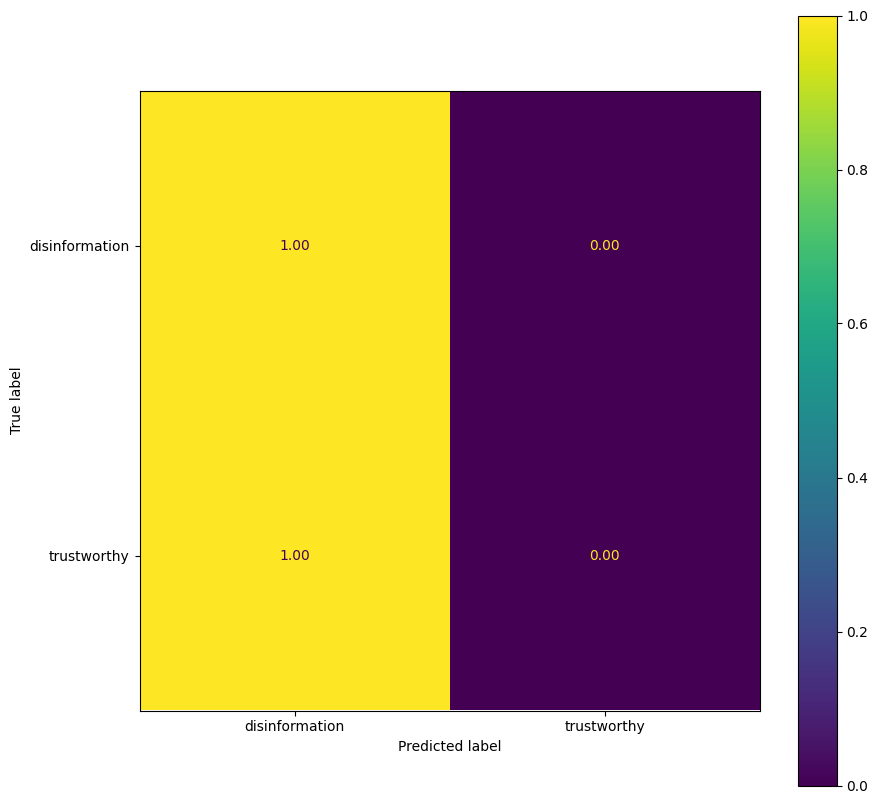

In [30]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
# Calculate confusion matrix
cm = confusion_matrix(true_labels, processed_outputs, normalize='true')

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(true_labels))
disp.plot(ax=ax, cmap='viridis', values_format='.2f')
fig.savefig("cfm_cot_gemma_fine_tuned.png")

In [31]:
y_true = true_labels
y_pred = processed_outputs
default_metrics = {
    'accuracy': accuracy_score,
    'recall': lambda y_t, y_p: recall_score(y_t, y_p, zero_division=1, average='macro'),
    'precision': lambda y_t, y_p: precision_score(y_t, y_p, zero_division=1, average='macro'),
    'f1': lambda y_t, y_p: f1_score(y_t, y_p, zero_division=1, average='macro')
}
cls_report = classification_report(y_true, y_pred, output_dict=True)
metrics = {metric_name: metric_func(y_true, y_pred) for metric_name, metric_func in default_metrics.items()}

/home/dstets/data/conda/envs/newllms/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dstets/data/conda/envs/newllms/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dstets/data/conda/envs/newllms/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [32]:
# Save metrics
with open("cot_gemma_tuned.txt", "w") as f:
    f.write(f"Metrics for COT learning with Llama model:\n")
    for metric_name, metric_value in metrics.items():
        f.write(f"{metric_name}: {metric_value}\n")
    f.write(f"\nClassification report:\n")
    for label, metrics in cls_report.items():
        f.write(f"{label}: {metrics}\n")